# Progetto Analisi di Immagini e Video


Il seguente notebook contiene l'addestramento della rete scelta e la sua valutazione sul test set.

In [ ]:
!nvidia-smi

Sun Jun 28 16:22:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Da modificare a seconda della locazione della cartella Drive.
rootPath = 'drive/My Drive/spacejam'

Sulla base degli elementi contenuti in annotationTrain e annotationTest, il dataset è stato suddiviso in due zip contenenti Training Set e Test Set per agevolare il lavoro di caricamento.

Si procede con il caricamento tramite unzip.

In [ ]:
rootPath = 'drive/My\ Drive/spacejam'
!unzip -x $rootPath'/train_video.zip'
!unzip -x $rootPath'/test_video.zip'

## Import Libraries

In [ ]:
SEED = 9126

import os
import json
import time
from datetime import datetime
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2
import sys

from PIL import Image
import pandas as pd
import numpy as np
np.random.seed(SEED)
from matplotlib import animation
from IPython.display import HTML

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report
from collections import Counter

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
numFrames=16

USE_CUDA = True
CUDA = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")

if CUDA:
    print('run on %s' % device)

#Metodi di utilità

In [ ]:
def save_ckp(state, checkpoint_path):
    """
    state: checkpoint we want to save
    checkpoint_path: path to save checkpoint
    """
    f_path = checkpoint_path+"/model.ckpt"
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)

def load_ckp(checkpoint_path, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_path+"/model.ckpt")
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

import time
from torch.autograd import Variable
from datetime import timedelta
import sys
def call_train(model, checkpoint_path,optimizer,start_epoch, totEpoch):
  cls_criterion = nn.CrossEntropyLoss().to(device)
  acc_tmp = 0
  for epoch in range(start_epoch, totEpoch+1):
    out_loss_train = open(checkpoint_path+"/lossTrain.txt", "a") #
    out_acc_train = open(checkpoint_path+"/accuracyTrain.txt", "a") #

    out_loss_test = open(checkpoint_path+"/lossTest.txt", "a") #
    out_acc_test = open(checkpoint_path+"/accuracyTest.txt", "a") #
    epoch_metrics = {"loss": [], "acc": []}
    epoch_metrics_test = {"loss": [], "acc": []}
    prev_time = time.time()
    print("---")
    print(f"--- Epoch {epoch} ---")
    for batch_i, (X, y) in enumerate(trainLoader):

      image_sequences = X.view(X.size(0),3,16,X.size(3),X.size(4)).to(device)
      labels = y.to(device)
      optimizer.zero_grad()

      # Get sequence predictions
      predictions = model(image_sequences)

      # Compute metrics
      loss = cls_criterion(predictions, labels)
      acc = 100 * (predictions.detach().argmax(1) == labels).cpu().numpy().mean()

      loss.backward()
      optimizer.step()

      # Keep track of epoch metrics
      epoch_metrics["loss"].append(loss.item())
      epoch_metrics["acc"].append(acc)

      # Determine approximate time left
      batches_done = epoch * len(trainLoader) + batch_i
      batches_left = (totEpoch+1) * len(trainLoader) - batches_done
      time_left = timedelta(seconds=batches_left * (time.time() - prev_time))
      prev_time = time.time()

      # Print log
      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)] ETA: %s"
          % (
              epoch,
              totEpoch,
              batch_i,
              len(trainLoader),
              loss.item(),
              np.mean(epoch_metrics["loss"]),
              acc,
              np.mean(epoch_metrics["acc"]),
              time_left
          )
      )
    acc_tmp = np.mean(epoch_metrics["acc"])
    loss_tmp = np.mean(epoch_metrics["loss"])



    correct_test = 0
    total_test = 0
    predictions_test = []
    labels_list_test = []
    loss2_test = 0
    with torch.no_grad():
        for batch_i,data in enumerate(testLoader):

            images, labels = data
            images = images.view(images.size(0),3,16, images.size(3), images.size(4)).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss_test = cls_criterion(outputs, labels)
            acc_test = 100 * (outputs.detach().argmax(1) == labels).cpu().numpy().mean()


            epoch_metrics_test["loss"].append(loss_test.item())
            epoch_metrics_test["acc"].append(acc_test)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            labels_list_test.extend(labels.cpu().numpy())
            predictions_test.extend(predicted.cpu().numpy())
            correct_test += (predicted == labels).sum().item()
            sys.stdout.write(
              f"\rEpoch: {epoch} -- Acc Train: {acc_tmp} ---- [{batch_i}/{len(testLoader)}] Accuracy Test: {100 * correct_test / total_test} ")
    acc_tmp_test = np.mean(epoch_metrics_test["acc"])
    loss_tmp_test = np.mean(epoch_metrics_test["loss"])
    sys.stdout.write(f' \r Acc Train: {"{:.2f}".format(acc_tmp)}% -- Acc Test {"{:.2f}".format(acc_tmp_test)}%')

    checkpoint = {
      'epoch': epoch + 1,
      'state_dict': model.state_dict(),
      'optimizer': optimizer.state_dict(),
    }

    out_loss_train.write('{} Loss: {:.4f}\n'.format(epoch, loss_tmp)) #
    out_acc_train.write('{} ACC: {:.4f}\n'.format(epoch, acc_tmp)) #

    out_loss_test.write('{} Loss: {:.4f}\n'.format(epoch, loss_tmp_test)) #
    out_acc_test.write('{} ACC: {:.4f}\n'.format(epoch, acc_tmp_test)) #

    out_acc_test.close() #
    out_acc_train.close() #

    out_loss_test.close() #
    out_loss_train.close() #

    save_ckp(checkpoint, checkpoint_path)

def getMetrics(model_path, set, type='txt'):

  def getMetrics_txt(model_path, set):
    if set == 'train':
      accPath = model_path+"/accuracyTrain.txt"
      lossPath = model_path+"/lossTrain.txt"

      accFile = open(accPath,'r')
      lossFile = open(lossPath,'r')
      acc = accFile.readlines()
      loss = lossFile.readlines()

      acc= ["{:.2f}".format(float(el.replace('\n','').split()[-1])) for el in acc]
      loss = ["{:.2f}".format(float(el.replace('\n','').split()[-1])) for el in loss]

      accFile.close()
      lossFile.close()

      return np.array(acc).astype(float), np.array(loss).astype(float)

    if set=='test':
      accPath = model_path+"/accuracyTest.txt"
      lossPath = model_path+"/lossTest.txt"

      accFile = open(accPath,'r')
      lossFile = open(lossPath,'r')
      acc = accFile.readlines()
      loss = lossFile.readlines()

      acc= ["{:.2f}".format(float(el.split()[-1])) for el in acc]
      loss = ["{:.2f}".format(float(el.split()[-1])) for el in loss]

      accFile.close()
      lossFile.close()

      return np.array(acc).astype(float), np.array(loss).astype(float)

    raise ValueError("I set disponibili sono 'train' o 'test'")

  def getMetrics_csv(model_path,set): #da cambiare quando mettiamo tutto in una cartella
    if set=='train':
      csv= pd.read_csv(model_path+'Train.csv')
      acc = csv[' acc']
      loss = csv['loss']
      return np.array(acc).astype(float), np.array(loss).astype(float)
    if set=='test':
      csv= pd.read_csv(model_path+'Test.csv')
      acc = csv[' acc']
      loss = csv['loss']
      return np.array(acc).astype(float), np.array(loss).astype(float)
    raise ValueError("I set disponibili sono 'train' o 'test'")



  if type=='txt':
    return getMetrics_txt(model_path, set)
  if type == 'csv':
    return getMetrics_csv(model_path,set)
  raise ValueError("Il tipo di file da caricare è diverso da 'txt' o 'csv'")


def plot(modelPath , step, type='txt'):
  accTrain, lossTrain = getMetrics(modelPath, 'train', type)
  accTest, lossTest = getMetrics(modelPath, 'test', type)
  epochs =  np.linspace(0, len(accTrain), len(accTrain))
  fig = plt.figure(figsize=(15,7))
  fig.add_subplot(1,2,1)
  plt.plot(epochs, accTrain, c='b', label="Accuracy Train")
  plt.plot(epochs, accTest, c='g', label ="Accuracy Test")
  plt.title("Accuracy")
  plt.xticks(range(0,len(accTrain)+1,step))
  plt.legend(loc="lower right")

  fig.add_subplot(1,2,2)
  plt.plot(epochs, lossTrain, c='orange', label = "Loss Train")
  plt.plot(epochs, lossTest, c='r', label = "Loss Test")
  plt.title("Loss")
  plt.xticks(range(0,len(lossTrain)+1,step))
  plt.legend(loc="upper right")


def load_model(model_architecture, checkpoint_path):
  model = model_architecture
  optimizer = torch.optim.SGD(model.parameters(), lr=1e-4) #serve solo per il caricamento del modello
  load_model,optimizer, start_epoch=load_ckp(checkpoint_path, model, optimizer)
  return load_model


def classify(model, dataset):
  correct = 0
  total = 0
  predictions = []
  y_true = []
  with torch.no_grad():
      for batch_i,data in enumerate(dataset):
          sys.stdout.write(
              f"\r{batch_i}/{len(dataset)}"
          )
          images, labels = data
          images = images.view(images.size(0),3,16, images.size(3), images.size(4)).to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          y_true.extend(labels.cpu().numpy())
          predictions.extend(predicted.cpu().numpy())
          correct += (predicted == labels).sum().item()

  print(f'\n Accuracy della rete composta da {len(annotationTest)} video: {100* correct/total}')

  return y_true, predictions



#Data Loading

## Caricamento Dataset

In [ ]:
TRAIN_FILE = 'train_video'
TEST_FILE = 'test_video'
KEYSET_FILE = rootPath+'/testset_keys.txt'

labels_dict = {0 : "block", 1 : "pass", 2 : "run", 3: "dribble",4: "shoot",
          5 : "ball in hand", 6 : "defense", 7: "pick" , 8 : "no_action" ,
          9: "walk" ,10: "discard"}

with open(os.path.join(rootPath+'/annotation_dict.json')) as fp:
    annotations = json.load(fp)

In [ ]:
with open(KEYSET_FILE) as fp:
    keys_test = json.load(fp)

annotationTrain = dict(filter(lambda x: x[0] not in keys_test, annotations.items()))
annotationTest = dict(filter(lambda x: x[0] in keys_test, annotations.items()))

print(f'Il numero totale di elementi è pari a {len(annotations)}, di cui:\n{len(annotationTrain)} appartenendi al Training Set \n{len(annotationTest)} appartenenti al Test Set')

Il numero totale di elementi è pari a 37085, di cui:
25959 appartenendi al Training Set 
11126 appartenenti al Test Set


In [ ]:
print ("Training set size:",int(len([name for name in os.listdir('/content/train_video') if os.path.isfile(os.path.join('/content/train_video', name))])))
print ("Test set size:",int(len([name for name in os.listdir('/content/test_video') if os.path.isfile(os.path.join('/content/test_video', name))])))

Training set size: 25959
Test set size: 11126


A titolo di esempio vengono mostrati 2 frame estratti da uno dei video contenuti nel dataset.

Shape torch.Size([16, 3, 176, 128])


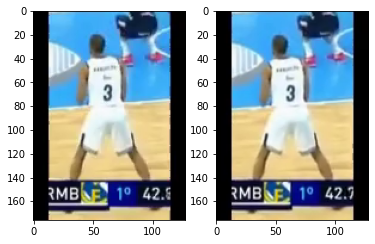

In [ ]:
transform = torchvision.transforms.ToTensor()

image = []

fname = os.path.join(TRAIN_FILE, '0018414.mp4')
video = cv2.VideoCapture(fname)
while (True):
    # Capture frame-by-frame
    ret, frame = video.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        frame = transform(Image.fromarray(frame))
        # print(frame.dtype)
        image.append(frame.unsqueeze(0))
    else:
        break
image = torch.cat(image, axis=0)

print('Shape', image.shape)

plt.subplot(121)
plt.imshow(image[0].numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(image[1].numpy().transpose(1, 2, 0));

## Distribuzione delle classi
Viene visualizzato come le classi sono distribuite all'interno del dataset SpaceJam.

Text(0.5, 1.0, 'Video by Category')

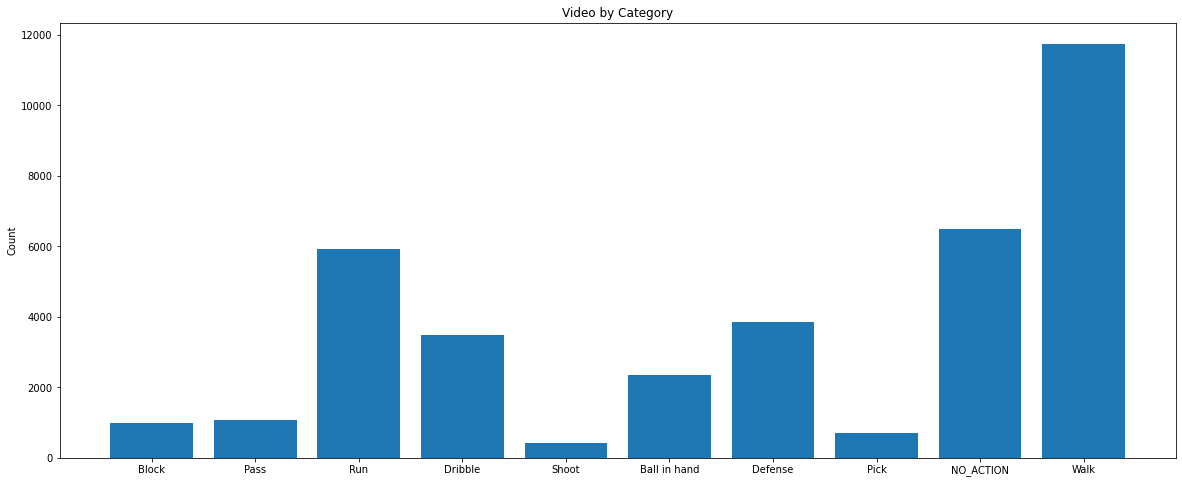

In [ ]:
tmp = Counter(list(annotations.values()))
occurrences = dict(tmp)

x = [k for k, v in occurrences.items()]
y = [v for k, v in occurrences.items()]
fig = plt.figure(figsize=(20, 8))
plt.bar(x, y)
plt.xticks(np.arange(10), ["Block","Pass","Run","Dribble","Shoot","Ball in hand","Defense","Pick","NO_ACTION","Walk"])
plt.ylabel('Count')
plt.title('Video by Category')

Si può notare come il dataset risulta fortemente sbilanciato, con minoranza delle classi: shoot, pick, block e pass.

## Creazione Dataset
A partire dai path dei video in annotationTrain e annotationTest viene definita la classe per la creazione del dataset che verrà poi caricato tramite DataLoader. La size scelta per i frame in input, dopo vari test, è stata fissata a (150x150).
Il modello scelto richiede un pre-processing in maniera tale che la resize dei frame dei video mantiene lo stesso aspect-ratio dei frame originali, semplicemente allargando i bordi neri ai margini.

Viene mostrato un esempio.

Shape (16, 150, 150, 3)


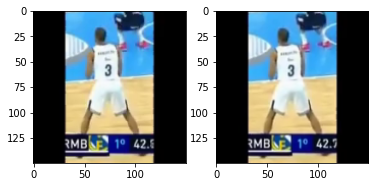

In [ ]:
image = []

fname = os.path.join(TRAIN_FILE, '0018414.mp4')
video = cv2.VideoCapture(fname)
while (True):
    # Capture frame-by-frame
    ret, frame = video.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        #Getting the bigger side of the image
        s = max(frame.shape[0:2])

        #Creating a dark square with NUMPY
        f = np.zeros((s,s,3),np.uint8)

        #Getting the centering position
        ax,ay = (s - frame.shape[1])//2,(s - frame.shape[0])//2

        #Pasting the 'image' in a centering position
        f[ay:frame.shape[0]+ay,ax:ax+frame.shape[1]] = frame

        image.append(cv2.resize(f,(150,150)))
    else:
        break
image = np.array(image)
print('Shape', image.shape)

plt.subplot(121)
plt.imshow(image[0])
plt.subplot(122)
plt.imshow(image[1]);

In [ ]:
class SpaceJamDataset(Dataset):
  def __init__(self, videoNames, labels, path):
    self.videoNames = videoNames
    self.labels = labels
    self.path = path

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    transform = torchvision.transforms.ToTensor()
    name = self.videoNames[index]
    images=[]
    videoName = os.path.join(self.path,name+'.mp4')
    video = cv2.VideoCapture(videoName)
    while(True):
      ret, frame = video.read()
      if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        #Getting the bigger side of the image
        s = max(frame.shape[0:2])

        #Creating a dark square with NUMPY
        f = np.zeros((s,s,3),np.uint8)

        #Getting the centering position
        ax,ay = (s - frame.shape[1])//2,(s - frame.shape[0])//2

        #Pasting the 'image' in a centering position
        f[ay:frame.shape[0]+ay,ax:ax+frame.shape[1]] = frame

        frame = cv2.resize(f,(150,150))
        frame = transform(Image.fromarray(frame))
        images.append(frame.unsqueeze(0))
      else:
        break
    images = torch.cat(images, axis=0)
    if(self.path=='train_video'):
      return images, torch.tensor(annotationTrain.get(name))

    return images, torch.tensor(annotationTest.get(name))

# Model

La scelta è ricaduta sull'architettura R(2+1)D. Questa è una variante spazio-temporale dell’architettura ResNet3D ed è formata da un blocco convoluzionale “(2 + 1) D”, che esplicitamente fattorizza la convoluzione 3D in due operazioni separate e successive: una convoluzione spaziale 2D e una convoluzione temporale 1D.

In [ ]:
from torchvision.models.video.resnet import VideoResNet, BasicBlock, R2Plus1dStem, Conv2Plus1D
def r2plus1d_34(num_classes, progress=False, arch=None):
    model = VideoResNet(block=BasicBlock,
                        conv_makers=[Conv2Plus1D] * 4,
                        layers=[3, 4, 6, 3],
                        stem=R2Plus1dStem)

    model.fc = nn.Linear(model.fc.in_features, out_features=num_classes)

    model.layer2[0].conv2[0] = Conv2Plus1D(128, 128, 288)
    model.layer3[0].conv2[0] = Conv2Plus1D(256, 256, 576)
    model.layer4[0].conv2[0] = Conv2Plus1D(512, 512, 1152)

    for m in model.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eps = 1e-3
            m.momentum = 0.9


    return model
model = r2plus1d_34(400)
model

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=0.001, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=0.001, momentum=0.9, affine=True, track_running_stats=Tru

# Training + Test

Per il training è stata sfruttata la tecnica del transfer learning a partire da un modello preaddestrato sui dataset IG-65M e Kinetics400 concesso da *Facebook Research*.

In [ ]:
model = r2plus1d_34(400)
path = rootPath+'/modelloScelto/r2plus1d_34_clip32_ft_kinetics_from_ig65m-ade133f1.pth'
model.load_state_dict(torch.load(path))
model.fc= nn.Linear(512,10)


In [ ]:
from pathlib import Path
checkpoint_path = '/content/drive/My Drive/spacejam/modelliProve/r(2+1)d_batch16_kinetic+ig65_(150,150)-same-aspect-ratio_lr=1e-3_dropout50%-lr=1e-4'
Path(checkpoint_path).mkdir(parents=True, exist_ok=True)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
call_train(model,checkpoint_path,optimizer,1,3)

--- Epoch 1 ---
 Acc Train: 62.65% -- Acc Test 68.46%----------------------
--- Epoch 2 ---
 Acc Train: 73.50% -- Acc Test 72.60%----------------------
--- Epoch 3 ---
 Acc Train: 80.86% -- Acc Test 73.55%----------------------


Da test effettuati abbiamo notato che dopo la terza epoca l'accuracy continua a crescere sul training set restando invariata sul test set, andando in overfitting. Per questo motivo abbiamo deciso di introdurre un livello di Dropout con *p=50%* e di abbassare il learning rate.

In [ ]:
model.add_module('dropout', nn.Dropout(p=0.5))
model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
call_train(model,checkpoint_path,optimizer,start_epoch,4)

--- Epoch 4 ---
 Acc Train: 90.89% -- Acc Test 76.47%----------------------


Nonostante il valore di accuracy nel training set si discosti di circa il 15% rispetto quella registrata nel test set, è stato scelto questo modello poichè sono state raggiunte le performance migliori in termini di precisione media.

#Test suite

In [ ]:
model = r2plus1d_34(400)
model.fc= nn.Linear(512,10)

In [ ]:
model = load_model(model, checkpoint_path).to(device)

In [ ]:
numBatch = 8

# Parameters
params = {'batch_size': numBatch,
          'shuffle': True,
          'num_workers': 8} #8

test_set = SpaceJamDataset(list(annotationTest.keys()), list(annotationTest.values()),'test_video')
testLoader = torch.utils.data.DataLoader(test_set, **params)

In [ ]:
y_true, y_pred = classify(model, testLoader)

1390/1391
 Accuracy della rete composta da 11126 video: 76.2807837497753


In [ ]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.65      0.65       272
           1       0.59      0.48      0.53       297
           2       0.81      0.84      0.82      1827
           3       0.88      0.87      0.87      1060
           4       0.65      0.52      0.58       128
           5       0.74      0.72      0.73       678
           6       0.70      0.67      0.69      1181
           7       0.62      0.47      0.54       207
           8       0.76      0.75      0.75      1962
           9       0.76      0.80      0.78      3514

    accuracy                           0.76     11126
   macro avg       0.72      0.68      0.69     11126
weighted avg       0.76      0.76      0.76     11126

